## 2 Basic Heat Pump

This notebook provides an example of how to run a basic heat pump controller. This system contains weather data, a house load, a heat pump, and a grid connection with fixed or agile prices.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
from pathlib import Path
current = os.path.abspath('')
parent = os.path.dirname(current)
sys.path.append(parent)

import matplotlib.pyplot as plt

In [3]:
import importlib
from datetime import datetime,tzinfo,timezone,timedelta
from collections import OrderedDict

import pandas as pd

import electrichouse as eh
from electrichouse.controllers import  PlanController,do_nothing_step_function
from electrichouse.components.inputs import (
    TempAndPVInputParams,
    TempAndPVComponent,
    HouseInflexibleLoadInputParams,
    HouseInflexibleLoadComponent,
)
from electrichouse.components.grid import (
    SingleRateTariffInputParams,
    SingleRateTariffComponent,
    OctopusAgileTariffComponent,
    GridInputParams,
    GridComponent,
)
from electrichouse.components.heating import HeatPumpComponent,HeatPumpInputParams

importlib.reload(eh)

<module 'electrichouse' from '/Users/benaylott/projects/electrichouse/electrichouse/__init__.py'>



## Run plan model 

In [4]:
def heat_pump_control(tandpv_outdoor_temp_C,**kwargs):
    return {
        "dhw_supply_active": False,
        "room_setpoint_temperature_C": 20.0,
        "outdoor_air_temperature_C": tandpv_outdoor_temp_C,
    }

def grid_control(hp_power_usage_kW,house_load_usage_kW,**kwargs): 
    return {"grid_requested_kw": -(hp_power_usage_kW + house_load_usage_kW)}

plan=OrderedDict({
    "tandpv":{
        "input_params":TempAndPVInputParams(
            weather_data_filepath=Path(f"{os.path.abspath('')}/../data/weather_data.csv"),
            weather_data_year= 2014,
            pv_power_kW= 3,
        ),
        "control_params_init":{},
        "class":TempAndPVComponent,
        "step_function":do_nothing_step_function,
    },  
    "house_load":{
        "input_params":HouseInflexibleLoadInputParams(
            data_csv_filepath=Path(f"{os.path.abspath('')}/../data/loadm.csv"),
        ),
        "control_params_init":{},
        "class":HouseInflexibleLoadComponent,
        "step_function":do_nothing_step_function,
    },
    "hp":{
        "input_params":HeatPumpInputParams(
            max_modulation=0.0,
            max_heat_output_kw=8,
            building_heat_loss_coefficient_Q_kW_K=0.2,
        ),
        "control_params_init":{},
        "class":HeatPumpComponent,
        "step_function":heat_pump_control,
    },
    "grid":{
        "input_params":GridInputParams(
            min_kw=-3.68,
            max_kw= 23,
        ),
        "control_params_init":{},
        "class":GridComponent,
        "step_function":grid_control,
    },
    "tariff":{
        "input_params":SingleRateTariffInputParams(
            grid_import_price_pounds_per_kWh= 0.3,
            grid_export_price_pounds_per_kWh= 0.05,
        ),
        "control_params_init":{},
        "class":SingleRateTariffComponent,
        "step_function":do_nothing_step_function,
    },
})

In [5]:
%%time
sc=PlanController(
    time_interval=timedelta(minutes=30),
    start_time=datetime(year=2021, month=1, day=1, tzinfo=timezone.utc),
    end_time=datetime(year=2022, month=1, day=1, tzinfo=timezone.utc),
    input_params={},
    control_params_init={},
    plan=plan,
)


outputp=[]
for res in sc:
    outputp.append(res)

CPU times: user 1.11 s, sys: 30.4 ms, total: 1.14 s
Wall time: 1.14 s


## Analyse model results

In [6]:
outputpp=pd.DataFrame.from_records(outputp,index='timestamp')

(convert index to DatetimeIndex to access convenience methods)

In [7]:
outputpp.index=pd.DatetimeIndex(outputpp.index)

In [8]:
outputpp.head()

tandpv_pv_generation_kW  tandpv_outdoor_temp_C  \
timestamp                                                                   
2021-01-01 00:00:00+00:00                      0.0                   4.60   
2021-01-01 00:30:00+00:00                      0.0                   4.79   
2021-01-01 01:00:00+00:00                      0.0                   4.98   
2021-01-01 01:30:00+00:00                      0.0                   5.17   
2021-01-01 02:00:00+00:00                      0.0                   5.36   

                           house_load_usage_kW  hp_room_temperature_C  \
timestamp                                                               
2021-01-01 00:00:00+00:00               -0.242                   20.0   
2021-01-01 00:30:00+00:00               -0.300                   20.0   
2021-01-01 01:00:00+00:00               -1.318                   20.0   
2021-01-01 01:30:00+00:00               -0.776                   20.0   
2021-01-01 02:00:00+00:00               -0.894                   20.0   

                           hp_power_usage_kW  hp_outdoor_air_temp_C  \
timestamp                                                             
2021-01-01 00:00:00+00:00          -1.021491                   4.60   
2021-01-01 00:30:00+00:00          -1.000983                   4.79   
2021-01-01 01:00:00+00:00          -0.980711                   4.98   
2021-01-01 01:30:00+00:00          -0.960674                   5.17   
2021-01-01 02:00:00+00:00          -0.940873                   5.36   

                           hp_heat_demand_kW    hp_cop  hp_heat_demand_met  \
timestamp                                                                    
2021-01-01 00:00:00+00:00              3.080  3.015201                True   
2021-01-01 00:30:00+00:00              3.042  3.039012                True   
2021-01-01 01:00:00+00:00              3.004  3.063085                True   
2021-01-01 01:30:00+00:00              2.966  3.087417                True   
2021-01-01 02:00:00+00:00              2.928  3.112005                True   

                           hp_dhw_heat_available_kW  grid_supplied_kW  \
timestamp                                                               
2021-01-01 00:00:00+00:00                  2.213933          1.263491   
2021-01-01 00:30:00+00:00                  2.278225          1.300983   
2021-01-01 01:00:00+00:00                  2.343254          2.298711   
2021-01-01 01:30:00+00:00                  2.409014          1.736674   
2021-01-01 02:00:00+00:00                  2.475497          1.834873   

                           tariff_grid_import_price_pounds_per_kWh  \
timestamp                                                            
2021-01-01 00:00:00+00:00                                      0.3   
2021-01-01 00:30:00+00:00                                      0.3   
2021-01-01 01:00:00+00:00                                      0.3   
2021-01-01 01:30:00+00:00                                      0.3   
2021-01-01 02:00:00+00:00                                      0.3   

                           tariff_grid_export_price_pounds_per_kWh  
timestamp                                                           
2021-01-01 00:00:00+00:00                                     0.05  
2021-01-01 00:30:00+00:00                                     0.05  
2021-01-01 01:00:00+00:00                                     0.05  
2021-01-01 01:30:00+00:00                                     0.05  
2021-01-01 02:00:00+00:00                                     0.05

Check energy balance = 0

In [9]:
outputpp[["hp_power_usage_kW","house_load_usage_kW","grid_supplied_kW"]].values.sum(axis=1).sum(axis=0)

0.0

### Outdoor / indoor temperature

<AxesSubplot: xlabel='timestamp'>

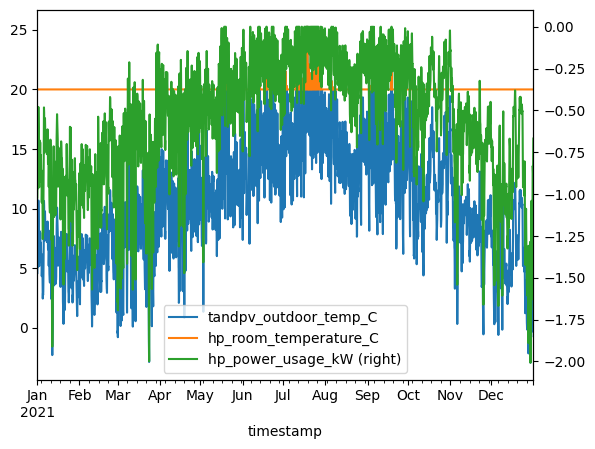

In [10]:
outputpp[["tandpv_outdoor_temp_C","hp_room_temperature_C","hp_power_usage_kW"]].plot(secondary_y=["hp_power_usage_kW"])